# Import qbiome

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

In [2]:
from qbiome.qutil import customDataFormatter

# Import other packages

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

# Data

In [48]:
dirname = 'example_data/'
data = dirname + 'hc_Phylum_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'

# Instantiate the data formatter, quantizer, qnet orchestrator

In [49]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']
data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"},BIOMES=BIOMES)

In [50]:
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

# Load, quantize, and convert the data to qnet input format

In [51]:
#data = formatter.load_data(data, meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

In [52]:
quantized.head()

,subject_id,Actinobacteriota_24,Actinobacteriota_26,Actinobacteriota_27,Actinobacteriota_28,Actinobacteriota_29,Actinobacteriota_30,Actinobacteriota_31,Actinobacteriota_32,Actinobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,100001,NaN,NaN,NaN,NaN,NaN,A,A,A,NaN,...,A,A,A,A,NaN,A,A,NaN,NaN,NaN
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,NaN,NaN,NaN,NaN,A,A,A,A,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,C,A,A,NaN,NaN,A,NaN,NaN,...,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,...,A,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN


In [53]:
len(features)

95

# Train qnet

In [54]:

# should take < 5 min to run
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.2, min_samples_split=2, 
    out_fname='data1.joblib')

# Use the mask checker to mask 20% of the label matrix and use qnet to predict

In [55]:
mask_checker = MaskChecker(qnet_orchestrator)

In [56]:
# takes 2 minutes to run
predicted = mask_checker.mask_and_predict(label_matrix, mask_percent=20)

In [57]:
predicted.head()

,subject_id,variable,week,value
0,100001,Actinobacteriota,24,NaN
1,100002,Actinobacteriota,24,NaN
2,100003,Actinobacteriota,24,NaN
3,100004,Actinobacteriota,24,NaN
4,100005,Actinobacteriota,24,NaN


# Plot the predicted vs. original biome measurements

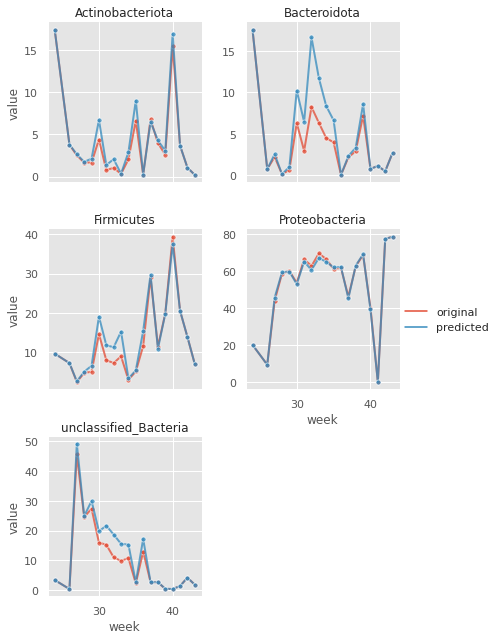

In [97]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

concat = pd.concat([
    data.assign(source='original'), 
    predicted.assign(source='predicted')
])
concat = concat[concat.variable.isin(BIOMES)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

It appears that the prediction passes our eyeball sanity check.

We zoom in to look at the first 20 weeks.

In [101]:
concat[(concat.subject_id==100001) & (concat.variable=='Actinobacteriota') & (concat.week.between(34,40))]

,sample_id,variable,value,subject_id,week,source
0,100001.c.062,Actinobacteriota,0.000000,100001,34,original
215,100001.c.064,Actinobacteriota,0.000000,100001,35,original
220,100001.c.066,Actinobacteriota,0.144941,100001,36,original
225,100001.c.067,Actinobacteriota,1.183892,100001,37,original
230,100001.c.069,Actinobacteriota,10.158041,100001,39,original
235,100001.c.070,Actinobacteriota,45.722674,100001,40,original
351,NaN,Actinobacteriota,1.663940,100001,34,predicted
390,NaN,Actinobacteriota,5.548504,100001,35,predicted
429,NaN,Actinobacteriota,0.080617,100001,36,predicted
468,NaN,Actinobacteriota,2.152221,100001,37,predicted


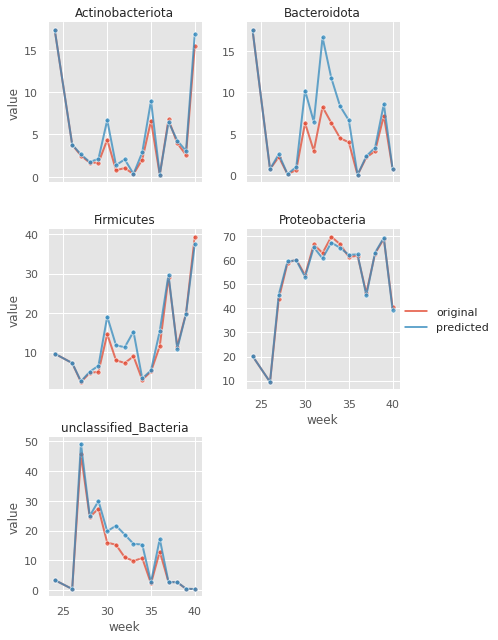

In [60]:
concat = concat[(concat.week <= 40)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

To increase the precision of the prediction, we can apply the random forest regressor in the quantizer. See the example below when we use the forecaster.

# Use the forecaster to sequentially mask part of the original data and predict

In [61]:
forecaster = Forecaster(qnet_orchestrator)

In [105]:
# takes 10 minutes to run
# can specify an end week or default to the max end week in the data
forecasted = forecaster.forecast_data(
    label_matrix, 
    start_week=31,
#     end_week=data.week.max()
)

In [107]:
label_matrix

array([['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan']], dtype='<U3')

## Apply the random forest regressor in the quantizer

In [64]:
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [65]:
dequantized_plot

,subject_id,variable,week,value
0,100001,Actinobacteriota,24,NaN
1,100002,Actinobacteriota,24,NaN
2,100003,Actinobacteriota,24,NaN
3,100004,Actinobacteriota,24,NaN
4,100005,Actinobacteriota,24,NaN
...,...,...,...,...
3700,100078,unclassified_Bacteria,43,NaN
3701,100083,unclassified_Bacteria,43,NaN
3702,100084,unclassified_Bacteria,43,NaN
3703,100090,unclassified_Bacteria,43,NaN


In [92]:
forecasted[(forecasted.subject_id==100001) & (forecasted.variable=='Actinobacteriota')]

,subject_id,variable,week,value
0,100001,Actinobacteriota,24,NaN
39,100001,Actinobacteriota,26,NaN
78,100001,Actinobacteriota,27,NaN
117,100001,Actinobacteriota,28,NaN
156,100001,Actinobacteriota,29,NaN
195,100001,Actinobacteriota,30,11.379829
234,100001,Actinobacteriota,31,NaN
273,100001,Actinobacteriota,32,NaN
312,100001,Actinobacteriota,33,NaN
351,100001,Actinobacteriota,34,5.016904


In [94]:
data[(data.subject_id==100001) & (data.variable=='Actinobacteriota')].sort_values('week')

,sample_id,variable,value,subject_id,week
15,100001.c.053,Actinobacteriota,0.046529,100001,30
10,100001.c.054,Actinobacteriota,0.063857,100001,31
5,100001.c.060,Actinobacteriota,0.021240,100001,32
0,100001.c.062,Actinobacteriota,0.000000,100001,34
215,100001.c.064,Actinobacteriota,0.000000,100001,35
220,100001.c.066,Actinobacteriota,0.144941,100001,36
225,100001.c.067,Actinobacteriota,1.183892,100001,37
230,100001.c.069,Actinobacteriota,10.158041,100001,39
235,100001.c.070,Actinobacteriota,45.722674,100001,40


In [83]:
avg_forecasted_regressed = quantizer.apply_random_forest_regressor(
    forecasted#.fillna(method='ffill')
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

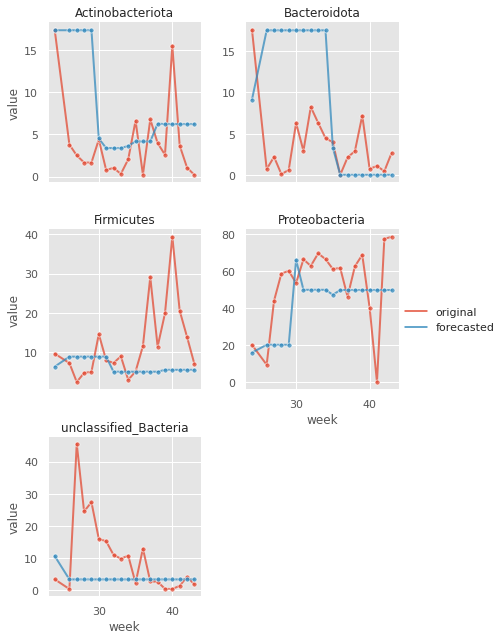

In [81]:
concat = pd.concat([
    data.assign(source='original'), 
    avg_forecasted_regressed.assign(source='forecasted')
])
concat = concat[concat.variable.isin(BIOMES)]
#concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

# Use the forecaster to predict new data

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [71]:
new_subject_id = '101'
np.random.seed(10001)
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = new_subject_id
new_patient

,subject_id,Actinobacteriota_24,Actinobacteriota_26,Actinobacteriota_27,Actinobacteriota_28,Actinobacteriota_29,Actinobacteriota_30,Actinobacteriota_31,Actinobacteriota_32,Actinobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,0.892232,0.694006,0.900454,0.584406,0.305097,...,0.949514,0.797598,0.71139,0.612895,0.919532,0.627349,0.311821,0.825716,0.535942,0.717411


In [72]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

(95,)

In [73]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=29, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [74]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', [new_subject_id])
new_patient_df

variable,subject_id,Actinobacteriota_24,Actinobacteriota_26,Actinobacteriota_27,Actinobacteriota_28,Actinobacteriota_29,Actinobacteriota_30,Actinobacteriota_31,Actinobacteriota_32,Actinobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)
new_patient_df

,subject_id,variable,week,value
0,101,Actinobacteriota,24,0.116507
1,101,Actinobacteriota,26,0.704285
2,101,Actinobacteriota,27,0.523539
3,101,Actinobacteriota,28,0.157700
4,101,Actinobacteriota,29,NaN
...,...,...,...,...
90,101,unclassified_Bacteria,39,NaN
91,101,unclassified_Bacteria,40,NaN
92,101,unclassified_Bacteria,41,NaN
93,101,unclassified_Bacteria,42,NaN


In [76]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)
new_patient_matrix.shape

(1, 95)

## Forecast the data starting from week 7 to the last week

In [77]:
# takes 2 minutes to run
new_patient_forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=29
)

In [78]:
new_patient_forecasted.head()

,subject_id,variable,week,value
0,101,Actinobacteriota,24,NaN
1,101,Actinobacteriota,26,NaN
2,101,Actinobacteriota,27,0.715988
3,101,Actinobacteriota,28,0.577774
4,101,Actinobacteriota,29,NaN


The NaNs are due to the random values we generated falling outside the quantization range.

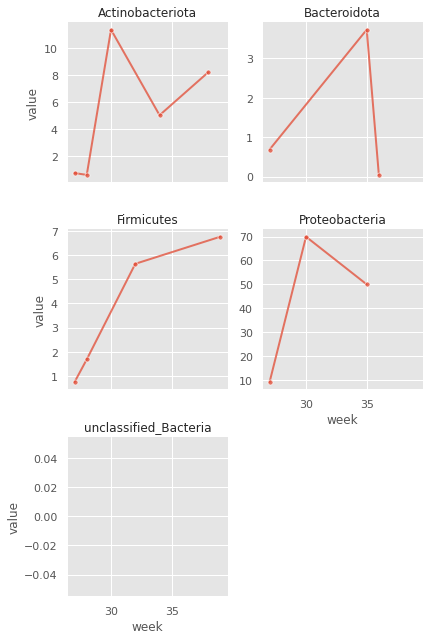

In [79]:
plottable = new_patient_forecasted[new_patient_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

In [ ]:
# zoom into the first 20 weeks
plottable = new_patient_forecasted[
    (new_patient_forecasted.variable.isin(BIOMES)) &
    (new_patient_forecasted.week <= 20)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()